# Project 1 - Delayed Flights within the United States
**Status**: 17.01.23    
This Notebook is an Exploratory Data Analysis to find patterns and insights why and how many flights are delayed in the US. The key research questions are
1. Which airlines do have the most delays?
1. Which lanes are mostly delayed?
1. Which flight haul types do have the most delays?
1. Which airports are causing the most delays?

Therefore the notebook is structured as follows:
1. General Business Understanding
1. Data Understanding
1. Data Preparation
1. Exploratory Data Analysis
1. Explainatory Data Analysis
1. Results


This analysis can be used later as a feature engineering notebook for predicting the delays of flights.

-----

# 1. Business Understanding

Delayed airplanes can be a major problem for the economy of the United States for a variety of reasons. Firstly, delays can cause disruptions to the travel plans of individuals and businesses, leading to lost time and productivity. This can be especially problematic for those who rely on air travel for work or have tight schedules to adhere to.

Additionally, delays can result in additional costs for both airlines and passengers, such as the need to book new flights or pay for unexpected accommodations. These costs can add up and have a negative impact on the bottom line for both the airline industry and the economy as a whole.

Furthermore, delays can lead to decreased customer satisfaction, which can ultimately harm the reputation of the airline industry and discourage people from flying in the future. This can also have a negative impact on the economy, as the airline industry plays a significant role in the transportation sector and contributes to overall economic growth.

Overall, the issue of delayed airplanes is a complex and multifaceted problem that can have far-reaching consequences for the economy of the United States.

*This was written by ChatGPT*


-----

# 2. Data Understanding

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import time

%matplotlib inline

#Package Version
print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('Seaborn:',sns.__version__)

Matplotlib: 3.6.2
Pandas: 1.3.5
Numpy: 1.22.0
Seaborn: 0.12.1


**This dataset comes from Kaggle [link](https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay?resource=download). The dataset collects about 540k flights within the USA. There are no hints, within which period of time the data was collected.**

The following assumptions will be used to work with the dataset:    
A. The data is collected for a specific time period (approximately 1 year)    
B. The data is complete and is not a subset of bigger dataset


The following columns are part of the Dataset

- **["id"]** : unique id of the row
- **["Airline"]** : commercial airline operated the flight
- **["Flight"]** :  the type of the aircraft
- **["AirportFrom"]** : from where the flight departed
- **["AirportTo"]** : the airport where the flight arrived
- **["DayofWeek"]** : which day of the week (1:Monday - 7:Sunday)
- **["Time"]** : departure time measured in minutes from midnight (in fact the range is 10-1439) [source](https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay/discussion/343573?focusReplyOnRender=true#2072803)
- **["Length"]** : duration of the flight in minutes [source](https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay/discussion/343573?focusReplyOnRender=true#2072803)
- **["Delay"]** : whether the flight was delayed or not,binary, 0:not delayed, 1:delayed


**Airline Iata Code, Number of flights and Name of Airline**
[source](https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay/discussion/349138?focusReplyOnRender=true)

The IATA codes of the Airlines in this dataset are the following, according to the frequency distribution:

**WN** 94,097 - Southwest    
**DL** 60,940 - Delta    
**OO** 50,254 - Skywest    
**AA** 45,656 - American Airlines   
**MQ** 36,605 - Envoy     
**US** 34,500 - There was a US Airways Express, which now has the symbol OH, and the new name is PSA    
**XE** 31,126 - JSX   
**EV** 27,983 - ExpressJet    
**UA** 27,619 - United Airlines    
**CO** 21,118 - There was a Continental Airlines, but now it is part of United Airlines    
**FL** 20,827 - There is no code for FL in both the sites accessed    
**9E** 20,686 - Endeavor     
**B6** 18,112 - Jetblue    
**YV** 13,725 - Mesa    
**OH** 12,630 - PSA     
**AS** 11,471 - Alaska     
**F9** 6,456 - Frontier     
**HA** 5,578 - Hawaiian    

In [2]:
#Read in the input as a dataframe file in the src folder
df_flights_raw = pd.read_csv("src/Airlines.csv", index_col="id")

#All columns are written in lowercase
df_flights_raw.columns = [col.lower() for col in df_flights_raw.columns]

In [3]:
#Shape of the dataframe
df_flights_raw.shape

(539383, 8)

In [4]:
#General information of the dataset
df_flights_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539383 entries, 1 to 539383
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   airline      539383 non-null  object
 1   flight       539383 non-null  int64 
 2   airportfrom  539383 non-null  object
 3   airportto    539383 non-null  object
 4   dayofweek    539383 non-null  int64 
 5   time         539383 non-null  int64 
 6   length       539383 non-null  int64 
 7   delay        539383 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 37.0+ MB


In [5]:
#Check whether we do have flights with the flight duration of 0 if so drop them
df_flights_raw[df_flights_raw["length"]==0]

,airline,flight,airportfrom,airportto,dayofweek,time,length,delay
id,,,,,,,,
179150,F9,106,DEN,MSP,6,635,0,0
182841,F9,107,MSP,DEN,6,851,0,0
188954,F9,103,MSP,DEN,7,375,0,0
445579,B6,493,BOS,SEA,7,1060,0,1


**Summary**

In total the input data has a size 539.383 rows and 8 columns. Each record is one flight. There are no missing values and no duplicates. But there are 4 flights which have a flight duration of 0 minutes. This could be because the flight was cancelled before it started or these entries are somehow corrputed. To answer the following three research questions
1) Which Airlines do have the most delays?
1) Which lanes are lostly delayed?
3) Which flight haul types do have the most delays?


We need to prepare the data and create some new features like  time, Weekends, and Lanes

------

# 3. Data Preparation

**ToDos**

A) Add a new column lane, which will use the from airport and the to airport     
B) Translated time column in datetime object with correct hour    
C) Delete rows where the duration of the flight is 0

A) Add a new Column lane, which will use the from airport and the to airport

In [6]:
df_flights_raw["lane"] = df_flights_raw["airportfrom"] + "-" + df_flights_raw["airportto"]

B) Translated Time Column in datetime object with correct time

In [7]:
#Function to translate the minutes into timestamps
def translate_time(timestamp):
    a = timestamp
    h = a // 60
    m = a % 60
    dt = time(hour=h, minute=m, second=0, microsecond=0)
    dt.isoformat(timespec='auto')
    return dt

In [8]:
df_flights_raw["starttime"] = df_flights_raw["time"].apply(translate_time)

In [9]:
df_flights_raw.head()

,airline,flight,airportfrom,airportto,dayofweek,time,length,delay,lane,starttime
id,,,,,,,,,,
1,CO,269,SFO,IAH,3,15,205,1,SFO-IAH,00:15:00
2,US,1558,PHX,CLT,3,15,222,1,PHX-CLT,00:15:00
3,AA,2400,LAX,DFW,3,20,165,1,LAX-DFW,00:20:00
4,AA,2466,SFO,DFW,3,20,195,1,SFO-DFW,00:20:00
5,AS,108,ANC,SEA,3,30,202,0,ANC-SEA,00:30:00


In [10]:
df_flights_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539383 entries, 1 to 539383
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   airline      539383 non-null  object
 1   flight       539383 non-null  int64 
 2   airportfrom  539383 non-null  object
 3   airportto    539383 non-null  object
 4   dayofweek    539383 non-null  int64 
 5   time         539383 non-null  int64 
 6   length       539383 non-null  int64 
 7   delay        539383 non-null  int64 
 8   lane         539383 non-null  object
 9   starttime    539383 non-null  object
dtypes: int64(5), object(5)
memory usage: 45.3+ MB


C) Delete rows where the duration of the flight is 0

In [11]:
df_flights_raw.drop(df_flights_raw[df_flights_raw["length"]==0].index, inplace = True)
print(df_flights_raw.shape)

(539379, 10)


# 4. Exploratory Data Analysis

In [12]:
df_flights_clean = df_flights_raw.copy()

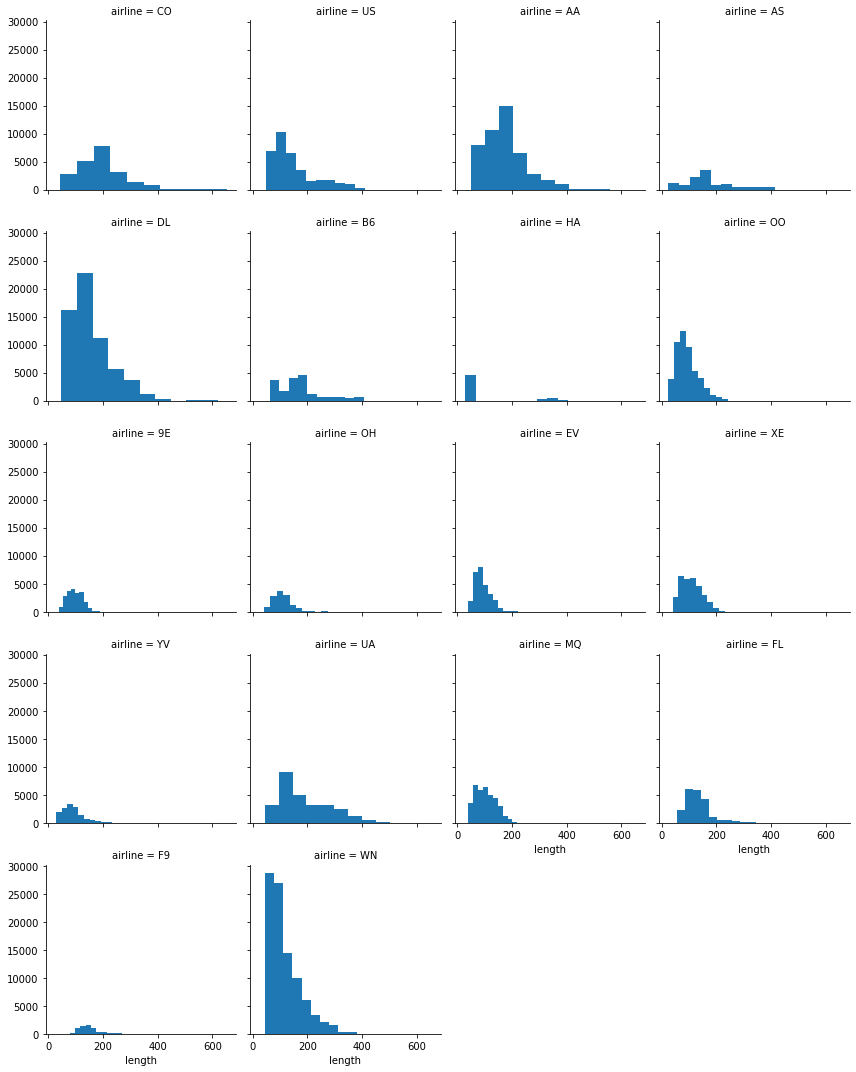

In [13]:
### Creating a FacetGrid to show the histogram of the duration of the flights per airline
g = sns.FacetGrid(data=df_flights_clean, col="airline", col_wrap=4)
g.map(plt.hist, "length");

# 5. Explainatory Data Analysis

1. **Which Airlines do have the most % delays?**
1. **Which lanes are mostly delayed?**
1. **Which flight haul types do have the most delays?**
1. **Which airports are causing the most delays?**

## 1.  Which Airlines do have the most delays?

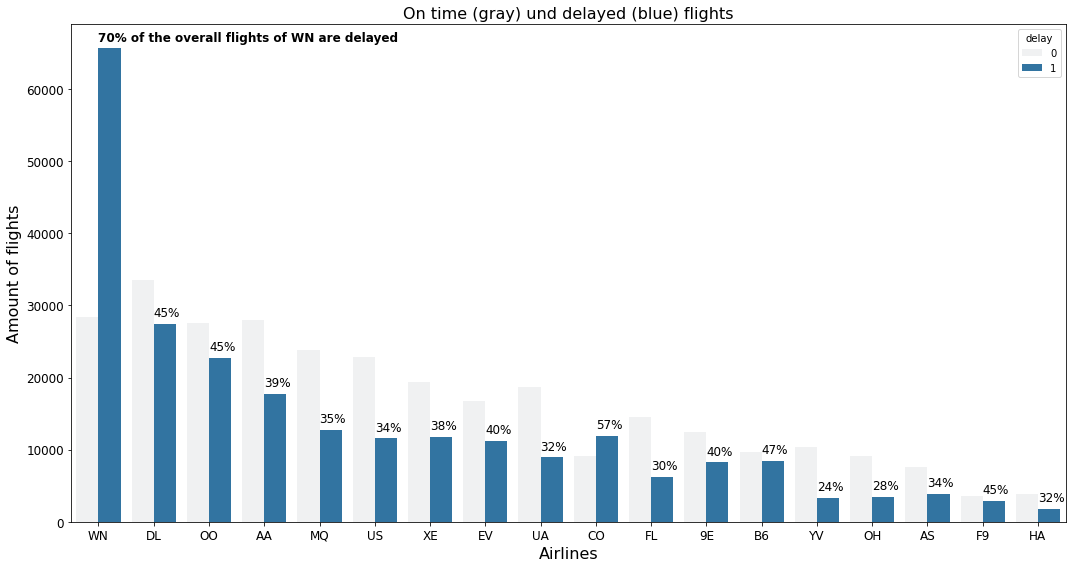

In [14]:
### Basic countplot ###
'''
Illustrating the flights per airline and whether it is to late or not
'''
plt.figure(figsize=(15, 8), layout="tight")
base_color = sns.color_palette()[0]
d = sns.countplot(
    x="airline",
    data=df_flights_clean,
    color=base_color,
    order=df_flights_clean["airline"].value_counts().index,
    hue="delay",
)
plt.xlabel("Airlines",fontsize=16)
plt.ylabel("Amount of flights",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
d.set_title("On time (gray) und delayed (blue) flights", fontsize=16);


#New Dataframe to calculate the delayed percentage per airline
airline_delay_percentage = df_flights_clean.groupby("airline").sum()
airline_delay_percentage["total"] = df_flights_clean.groupby("airline").delay.count()
airline_delay_percentage.drop(["flight", "dayofweek", "time", "length"], axis=1, inplace=True)
airline_delay_percentage["percentage"] = np.round((airline_delay_percentage.delay / airline_delay_percentage.total) * 100, decimals=0)



#Creating the annotation for each delayed bar of the diagram to incorporate the percentage delay per airline
locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    airline_delay_percentage_txt = airline_delay_percentage.loc[label._text, "percentage"]
    
    if loc == 0 :
        plt.text(
            x=loc,
            y=(airline_delay_percentage.loc[label._text, "delay"]) +1500,
            s=f"{int(airline_delay_percentage_txt)}% of the overall flights of {label._text} are delayed",
            va="center",
            color="black",
            fontweight=600,
            fontsize="large"
        )
    else:
        plt.text(
            x=loc,
            y=(airline_delay_percentage.loc[label._text, "delay"]) +1500,
            s=f"{int(airline_delay_percentage_txt)}%",
            va="center",
            color="black",
            fontsize="large"
        )
plt.savefig("picture/airline_delays.png", dpi=360)

**INSIGHT:**  

Two out of 18 airlines within the US do have a higher chance to be delayed than to be on point. Southwest airlines (70% delayed) and Continental Airlines (57% delayed). For 15 airlines more than 25% of the flights are delayed.

## 2. Which lanes are mostly delayed?

In [15]:
"""
Creating a new dataframe with the name lane_df, which groups the flights according to 
there lane and adds up the amount of delays and the total number of flights
"""
lane_df = df_flights_clean.groupby("lane").sum()
lane_df["total"] = df_flights_clean.groupby("lane").delay.count()
lane_df.drop(["flight", "dayofweek", "time", "length"], axis=1, inplace=True)
lane_df["percentage"] = np.round((lane_df.delay / lane_df.total) * 100, decimals=2)
lane_df.head()

,delay,total,percentage
lane,,,
ABE-ATL,7,31,22.58
ABE-CLT,2,31,6.45
ABE-DTW,40,85,47.06
ABE-FLL,4,17,23.53
ABE-MCO,9,31,29.03


In [16]:
#Amount of lanes
len(lane_df.index)

4190

Creating a **histogram**, to show the distribution of the <code>'lanes'</code>.

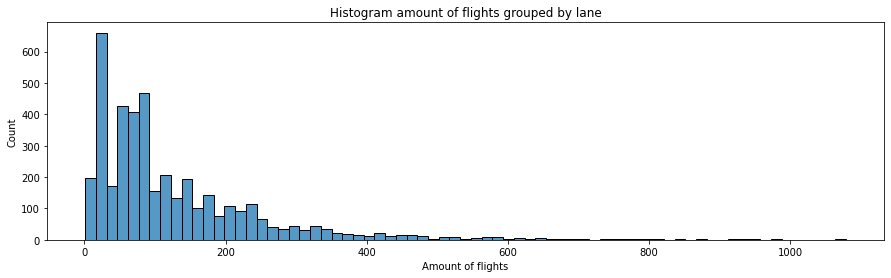

In [17]:
### Histogram of the lanes ###
plt.figure(figsize=(15, 4))
d = sns.histplot(lane_df["total"])
d.set_xlabel("Amount of flights")
d.set_title("Histogram amount of flights grouped by lane");

In [18]:
print("Amount of lanes 1 flight per day:", len(lane_df[lane_df["total"]>=365]))
print("Amount of lanes 2 flight per day:", len(lane_df[lane_df["total"]>=365*2]))
print("Amount of lanes 3 flight per day:", len(lane_df[lane_df["total"]>=365*3]))

Amount of lanes 1 flight per day: 221
Amount of lanes 2 flight per day: 26
Amount of lanes 3 flight per day: 0


In [19]:
#5 Key Metrics
lane_df.describe()

,delay,total,percentage
count,4190.000000,4190.000000,4190.000000
mean,57.342005,128.730072,44.469554
std,60.504864,127.851366,18.168777
min,0.000000,1.000000,0.000000
25%,19.000000,48.000000,32.182500
50%,36.000000,88.000000,42.215000
75%,75.000000,172.000000,54.760000
max,598.000000,1079.000000,100.000000


**INSIGHT:**

In total there are 4190 directonal lanes. 50 % of the lanes have a frequency of 88 or less. There are 221 lanes which have more than 1 flight per day, and 26 with more than 2 flights per day.

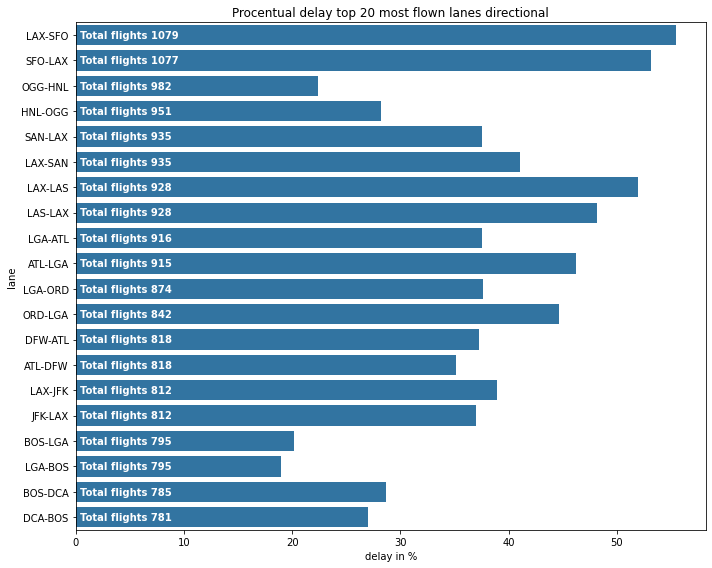

In [20]:
### Diagram for the top 20 most flown lanes, sorted by total amount of flights ###
top_20 = lane_df.sort_values(by="total", ascending=False)[:20]

plt.figure(figsize=(10, 8), layout='tight')
base_color = sns.color_palette()[0]
d = sns.barplot(
    y=top_20.index,
    x="percentage",
    data=top_20,
    color=base_color,
    order=top_20.index,
    orient="h",
)

locs, labels = plt.yticks()

for loc, label in zip(locs, labels):
    total_flights = top_20.loc[label.get_text(), "total"]

    plt.text(
        x=0.4,
        y=loc,
        s=f"Total flights {total_flights}",
        va="center",
        color="white",
        fontweight=650,
    )

d.set_ylabel("lane")
d.set_xlabel("delay in %")
d.set_title("Procentual delay top 20 most flown lanes directional");

plt.savefig("picture/lanes_directional.png", dpi=360)

In [21]:
lane_df.describe()

,delay,total,percentage
count,4190.000000,4190.000000,4190.000000
mean,57.342005,128.730072,44.469554
std,60.504864,127.851366,18.168777
min,0.000000,1.000000,0.000000
25%,19.000000,48.000000,32.182500
50%,36.000000,88.000000,42.215000
75%,75.000000,172.000000,54.760000
max,598.000000,1079.000000,100.000000


In [22]:
top_20.describe()

,delay,total,percentage
count,20.000000,20.000000,20.000000
mean,337.450000,888.900000,37.348000
std,122.695805,90.942955,10.717184
min,151.000000,781.000000,18.990000
25%,257.250000,812.000000,28.540000
50%,322.500000,894.500000,37.545000
75%,393.750000,935.000000,45.052500
max,598.000000,1079.000000,55.420000


**INSIGHT:**

The average delay above all 4190 directional lanes is 44.5%.This means for every lane every second flight is delayed. If you observe the Top 20 most used lanes the average flight delay reduces by 4 procent points. If you fly from LAX to SFO you have a 2 percent higher chance to be delayed than if you fly from SFO to LAX.

In [23]:
#creates a new Dataframe, where each lane in both directions only exists once
# LAX-SFO and SFO-LAX are the same lane

def compare_lanes(df):
    delete_list = []
    for index_zeile, row in df.iterrows():
        if index_zeile in df.index:
            for i in range(len(df)):
                if (set(index_zeile.split('-')) == set(df.index[i].split('-'))) and (index_zeile.split('-') != df.index[i].split('-')):
                    #print("index_zeile:,",index_zeile, "zu löschendes:", df.iloc[i].name)
                    df.loc[index_zeile,"delay"] += df.iloc[i]["delay"]
                    df.loc[index_zeile,"total"] += df.iloc[i]["total"]
                    df.drop(df.iloc[i].name, axis=0, inplace=True)
                    #delete_list.append(df.iloc[i].name)
                    break
    return df

In [24]:
"""
Creating a new dataframe with the name unique_lane_df, which groups the lanes if they go in both directions
LAX-SFO and SFO-LAX to one unique lane and adds up the amount of delays and the total number of flights
"""
unique_lane_df = df_flights_clean.groupby("lane").sum()
unique_lane_df["total"] = df_flights_clean.groupby("lane").delay.count()
unique_lane_df.drop(["flight", "dayofweek", "time", "length"], axis=1, inplace=True)
compare_lanes(unique_lane_df)
unique_lane_df["percentage"] = np.round((unique_lane_df.delay / unique_lane_df.total) * 100, decimals=2)
unique_lane_df.head()

,delay,total,percentage
lane,,,
ABE-ATL,24,62,38.71
ABE-CLT,11,62,17.74
ABE-DTW,83,170,48.82
ABE-FLL,5,34,14.71
ABE-MCO,20,62,32.26


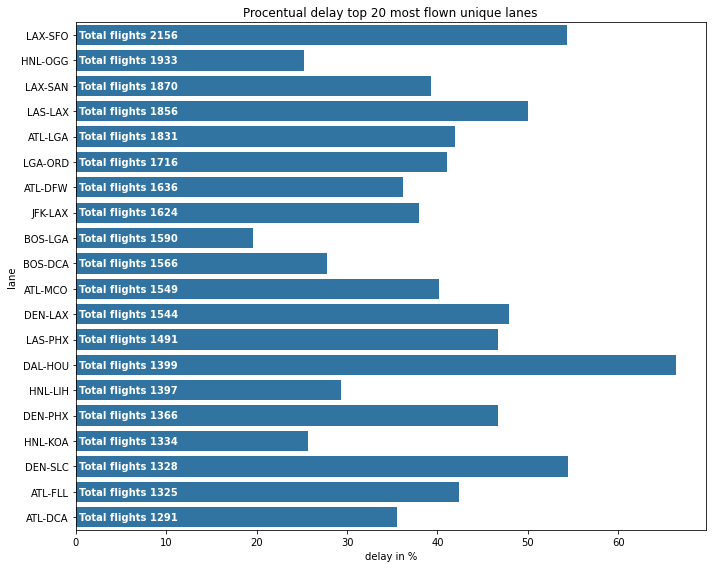

In [25]:
### Diagram for the top 20 most flown unique lanes, sorted by total amount of flights ###
top_20 = unique_lane_df.sort_values(by="total", ascending=False)[:20]

plt.figure(figsize=(10, 8), layout='tight')
base_color = sns.color_palette()[0]
d = sns.barplot(
    y=top_20.index,
    x="percentage",
    data=top_20,
    color=base_color,
    order=top_20.index,
    orient="h",
)

locs, labels = plt.yticks()

for loc, label in zip(locs, labels):
    total_flights = top_20.loc[label.get_text(), "total"]

    plt.text(
        x=0.4,
        y=loc,
        s=f"Total flights {total_flights}",
        va="center",
        color="white",
        fontweight=650,
    )

d.set_ylabel("lane")
d.set_xlabel("delay in %")
d.set_title("Procentual delay top 20 most flown unique lanes");

plt.savefig("picture/unique_lanes.png", dpi=360)

In [26]:
unique_lane_df.describe()

,delay,total,percentage
count,2103.000000,2103.000000,2103.000000
mean,114.247741,256.480742,44.441060
std,119.533075,255.617330,16.124132
min,0.000000,1.000000,0.000000
25%,38.000000,93.000000,33.535000
50%,73.000000,174.000000,41.940000
75%,150.000000,342.000000,53.120000
max,1170.000000,2156.000000,100.000000


**INSIGHT:**

If you have a look at the unique lanes in total 2103 (unique means SFO-LAX and LAX-SFO are counted as the same) the most flown unique lane Los Angeles (LAX) — San Francesco (SFO) with over 2156 flights has chance of delay of 54.27%. Dallas (DAL) — Houston (HOU) over 66%. But there are also positives examples like the flights between Honolulu (HNL) and Kahului (OGG) which only have a delay percentage of 25%. Probably because of the short flight duration and distance and a less busy airspace.

In [27]:
len(unique_lane_df[unique_lane_df["percentage"]<50])

1458

In [28]:
len(unique_lane_df[unique_lane_df["percentage"]>=50])

645

In [29]:
df_flights_clean.head()

,airline,flight,airportfrom,airportto,dayofweek,time,length,delay,lane,starttime
id,,,,,,,,,,
1,CO,269,SFO,IAH,3,15,205,1,SFO-IAH,00:15:00
2,US,1558,PHX,CLT,3,15,222,1,PHX-CLT,00:15:00
3,AA,2400,LAX,DFW,3,20,165,1,LAX-DFW,00:20:00
4,AA,2466,SFO,DFW,3,20,195,1,SFO-DFW,00:20:00
5,AS,108,ANC,SEA,3,30,202,0,ANC-SEA,00:30:00


## 3. Which flight haul types do have the most delays?

According to the IATA (International Air Transport Association) there are different categories of flight durations also called Flight haul types:

- **short-haul:** < 3 hours      
- **medium-haul:** 3 - 6 hours     
- **long-haul:** 6 - 16 hours    
- **ultra-long-haul:** > 16 hours    


In [30]:
#Creating a new column to use the column length and categorise the haul types
df_flights_clean.loc[df_flights_clean.length < 180,"haul_type"] = 's'
df_flights_clean.loc[(df_flights_clean['length'] >= 180) & (df_flights_clean['length'] < 360) ,"haul_type"] = 'm'
df_flights_clean.loc[(df_flights_clean['length'] >= 360) & (df_flights_clean['length'] < 960) ,"haul_type"] = 'l'
df_flights_clean.loc[df_flights_clean.length >= 960,"haul_type"] = 'xl'


#parse column as categorical to be faster in progressing later
df_flights_clean['haul_type']=pd.Categorical(df_flights_clean['haul_type'])

In [31]:
haul_df = df_flights_clean.groupby("haul_type").sum()
haul_df['total'] = df_flights_clean.groupby('haul_type').delay.count()
haul_df.drop(["flight", "dayofweek", "time", "length"], axis=1, inplace=True)
haul_df["percentage"] = np.round((haul_df.delay / haul_df.total) * 100, decimals=2)

In [32]:
haul_df

,delay,total,percentage
haul_type,,,
l,3090,6782,45.56
m,46756,93619,49.94
s,190417,438978,43.38


In [33]:
# Writing a fuction to create the percentage of the different haul types

def percentage_blocks (df, var):
    
    percentages = 100 * df[var] / df[var].sum()
    counts = np.floor(percentages).astype(int)
    decimal = (percentages - counts).sort_values(ascending=False)
    
    rem = 100 - counts.sum()
    for cat in decimal.index[:rem]:
        counts[cat] += 1
        
    return counts

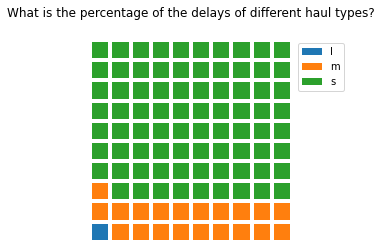

In [34]:
#Creating the waffle plot

column = 'delay'
waffle_counts = percentage_blocks(haul_df, column)

prev_count = 0

for cat in range(0,waffle_counts.shape[0]):
    blocks = np.arange(prev_count, prev_count + waffle_counts[cat], 1)
    
    x = blocks % 10
    
    y= blocks // 10
    
    plt.bar(x=x, height=0.8, width=0.8, bottom = y)
    prev_count += waffle_counts[cat]


plt.legend(waffle_counts.index.sort_values(), bbox_to_anchor=(0.97, 0.93))
plt.axis('off')
plt.title('What is the percentage of the delays of different haul types?')
plt.axis('square')


plt.savefig("picture/waffle_haul_types.png", dpi=360)

**INSIGHT:**

When categorising the data into the different haul_types  
- **short haul:** less than 3 hours    
- **medium haul:** 3 - 6 hours    
- **long haul:** 6 - 16 hours    
- **ultra-long haul:** more than 16 hours   

Only 1,2% of the flights that are delayed are long haul flights between 6-16 hours. 10% are medium haul flights between 3 and 6 hours. The majority (89%) are short haul flights less than 3 hours. There are no delayed ultra-long haul flights in this dataset. 43% of the short haul flights are delayed. 50% of the medium haul flights and 46% of the long haul flights. On the first view it seems like there are no correlation between the haul_type and delay.

## 4. Which airports are causing the most delays?

In [35]:
#created new df to group by departure Airports
fromAirports_df = df_flights_clean.groupby("airportfrom").sum()
fromAirports_df["total"] = df_flights_clean.groupby("airportfrom").delay.count()
fromAirports_df.drop(["flight", "dayofweek", "time", "length"], axis=1, inplace=True)
fromAirports_df["percentage"] = np.round((fromAirports_df.delay / fromAirports_df.total) * 100, decimals=2)

In [36]:
#created new df to group by departure Airports
toAirports_df = df_flights_clean.groupby("airportto").sum()
toAirports_df["total"] = df_flights_clean.groupby("airportto").delay.count()
toAirports_df.drop(["flight", "dayofweek", "time", "length"], axis=1, inplace=True)
toAirports_df["percentage"] = np.round((toAirports_df.delay / toAirports_df.total) * 100, decimals=2)

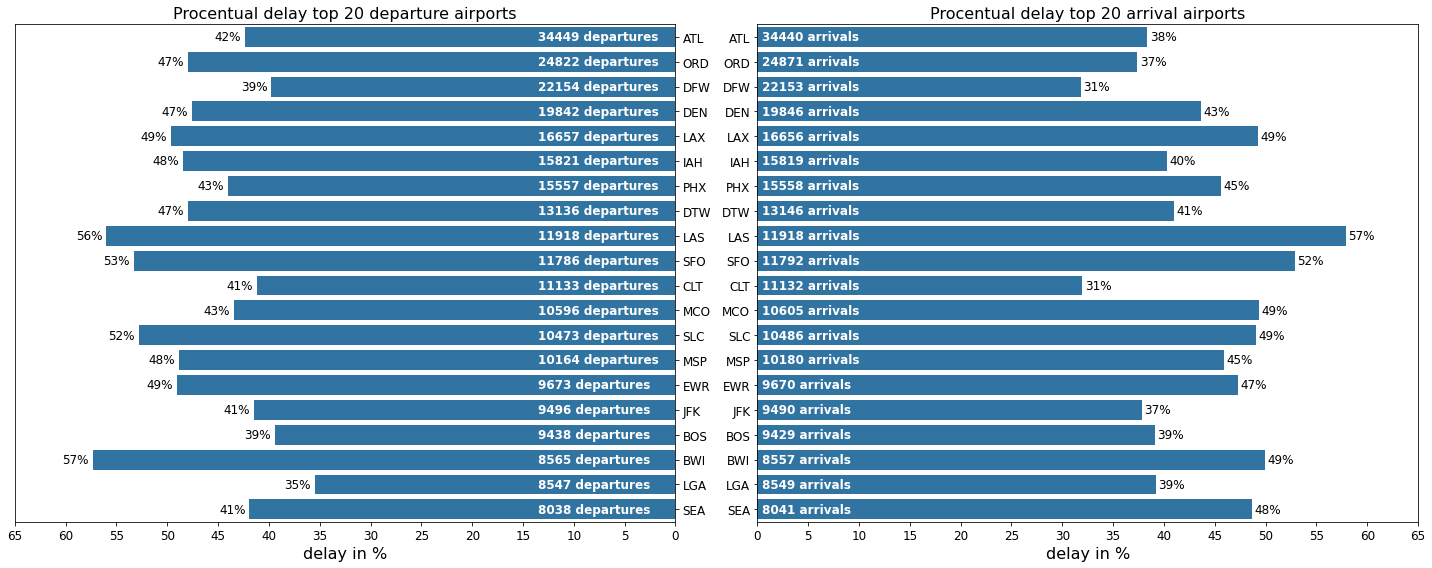

In [37]:
### Direct comparison between departure and arrival airports

d, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8), layout='tight')


### Diagram for the top 20 most delayed departure airports, sorted by total amount of flights ###
top_20 = fromAirports_df.sort_values(by="total", ascending=False)[:20]
plt.subplot(1,2,1)
d = sns.barplot(
    y=top_20.index,
    x="percentage",
    data=top_20,
    color=base_color,
    order=top_20.index,
    orient="h",
)
locs, labels = plt.yticks()

### Annotation of total flights
for loc, label in zip(locs, labels):
    total_flights = top_20.loc[label.get_text(), "total"]

    plt.text(
        x=13.5,
        y=loc,
        s=f"{total_flights} departures",
        va="center",
        color="white",
        fontweight=650,
        fontsize="large"
    )

### Annotation of the percentage
for loc, label in zip(locs, labels):
    plt.text(
        x=top_20.iloc[loc,2]+3,
        y=loc,
        s=f"{int(top_20.iloc[loc,2])}%",
        va="center",
        color="black",
        fontsize="large"
    )
    
plt.xlabel("delay in %",fontsize=16)
d.xaxis.set_ticks(np.arange(0, 70, 5))
d.invert_xaxis()
d.yaxis.tick_right()
plt.ylabel("",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
d.set_title("Procentual delay top 20 departure airports", fontsize=16)

### Diagram for the top 20 most delayed arrival airports, sorted by total amount of flights ###
plt.subplot(1,2,2)
top_20 = toAirports_df.sort_values(by="total", ascending=False)[:20]
d = sns.barplot(
    y=top_20.index,
    x="percentage",
    data=top_20,
    color=base_color,
    order=top_20.index,
    orient="h",
)

locs, labels = plt.yticks()

### Annotation of total flights
for loc, label in zip(locs, labels):
    total_flights = top_20.loc[label.get_text(), "total"]

    plt.text(
        x=0.5,
        y=loc,
        s=f"{total_flights} arrivals",
        va="center",
        color="white",
        fontweight=650,
        fontsize="large"
    )
    
### Annotation of the percentage    
for loc, label in zip(locs, labels):
    plt.text(
        x=top_20.iloc[loc,2]+0.25,
        y=loc,
        s=f"{int(top_20.iloc[loc,2])}%",
        va="center",
        color="black",
        fontsize="large"
    )

plt.xlabel("delay in %",fontsize=16)
d.xaxis.set_ticks(np.arange(0, 70, 5))
plt.ylabel("",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
d.set_title("Procentual delay top 20 arrival airports", fontsize=16)


plt.savefig("picture/airports.png", dpi=360)

In [38]:
print("Amount of departure airports where the chance of delay is bigger 50% :",len(fromAirports_df[fromAirports_df["percentage"]>=50.0]))
print("Amount of departure airports where the chance of delay is bigger 50% :",len(toAirports_df[toAirports_df["percentage"]>=50.0]))

Amount of departure airports where the chance of delay is bigger 50% : 32
Amount of departure airports where the chance of delay is bigger 50% : 71


In [39]:
fromAirports_df.sort_values(by='percentage', ascending=False)

,delay,total,percentage
airportfrom,,,
MDW,5222,7103,73.52
DAL,2748,3838,71.60
OAK,2697,3783,71.29
HOU,2949,4420,66.72
OTH,59,93,63.44
...,...,...,...
TEX,4,27,14.81
GTR,9,61,14.75
HTS,7,57,12.28


**INSIGHT:**

Interesting to see is that Top 20 departure airports and arrival airports are the same and in the same order (sorted by total amount of flight departures or arrivals). This is an indicator that they are by far the most used airports in the US. If you depart from Atlanta you have a four percent point higher chance to be delayed than if you would arrive there. In Chicago (ORD) you have a 10 % higher chance to depart late than to arrive late. The same applies for Charlotte. If you arrive in Seattle your chance is 7% higher to arrive late than if you would depart late from there. In total 32 airports have a chance of 50% or higher to depart late. 71 airports have a change of 50% or higher to arrive late.


# 6. Results

After analysing the data and doing some additional research the quality of the data seems to be questionable. It seems that the dataset provided to kaggle is a subset of bigger dataset. An average delay of 44% of all flights seems to be rather high. The Bureau of Transportation Statistics of the United States department of Transportation shows data from 2013 to 2022 [link](https://www.transtats.bts.gov/homedrillchart.asp). On average there is a delay round about 18%. It seems that the data provided on the Kaggle platform is not complete. Hence the analysis can only be interpreted correctly with the two assumptions provided at the beginning of the analysis in mind:

A. The data is collected for a specific time period (approximately 1 year)    
B. The data is complete and is not a subset of bigger dataset


## Further Research Topics

1. Is there a relation between the delay from flights from west to east, north to south or any other direction?
1. Do specific states within the US have more airports or lanes which have or cause delays?
1. Do bigger airports cause more or less delays?
1. Is there a correlation between delay and time of the day?
1. Can we predict delays if we create more features like the flight haul or size of airports?